# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

In [57]:
from crvusdsim.pool import get
from src.modules import ExternalMarket
from src.agents.arbitrageur import Arbitrageur
from src.sim.scenario import Scenario
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""
The way this should work:
1. Get all stableswap pools and relevant external markets
2. Create a list of all possible cycles of the form:
    [Flashswap] -> StableSwap Pool -> StableSwap Pool -> External Market
    TODO how to handle flashswap fee/slippage?
3. For each cycle: Optimize amount into first trade to maximize profit.
    This is done by creating a cycle object and optimizing the amount into
    the first trade. Then we can use `minimize_scalar` on the `execute()` method.
4. Execute most profitable cycle.
5. Repeat steps 3-4 until no profitable cycles remain.

TODO maybe there should be a class that holds all the pools. That way I can always just
pass in a single variable to any agent or function! This could just be a hashmap like:

pools: defaultdict(list) = {
    # <type> : []
    "SimCurveStableSwapPool": [],
    "SimLLAMMAPool": [],
    "SimCurvePool": [],
    "ExternalMarket": [],
}
"""

'\nThe way this should work:\n1. Get all stableswap pools and relevant external markets\n2. Create a list of all possible cycles of the form:\n    [Flashswap] -> StableSwap Pool -> StableSwap Pool -> External Market\n    TODO how to handle flashswap fee/slippage?\n3. For each cycle: Optimize amount into first trade to maximize profit.\n    This is done by creating a cycle object and optimizing the amount into\n    the first trade. Then we can use `minimize_scalar` on the `execute()` method.\n4. Execute most profitable cycle.\n5. Repeat steps 3-4 until no profitable cycles remain.\n\nTODO maybe there should be a class that holds all the pools. That way I can always just\npass in a single variable to any agent or function! This could just be a hashmap like:\n\npools: defaultdict(list) = {\n    # <type> : []\n    "SimCurveStableSwapPool": [],\n    "SimLLAMMAPool": [],\n    "SimCurvePool": [],\n    "ExternalMarket": [],\n}\n'

In [3]:
arbitrageur = Arbitrageur()

ETH_POOL = "weth"
(
    pool,
    controller,
    collateral_token,
    stablecoin,
    aggregator,
    stableswap_pools,
    peg_keepers,
    policy,
    factory,
) = get(ETH_POOL, bands_data="controller")

In [4]:
# Verify snapshot context works on StableSwap pools from crvusdsim
i, j = 1, 0

stableswap_pool = stableswap_pools[2]
high = stableswap_pool.get_max_trade_size(i, j)
prev_bals = stableswap_pool.balances.copy()

print("Pre Trade")
print("Balances", prev_bals)
print("High", high)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
print()

with stableswap_pool.use_snapshot_context():
    amt_out = stableswap_pool.trade(i, j, high)
    swap_bals = stableswap_pool.balances.copy()
    print("Post Trade")
    print("Amount out", amt_out)
    print("Balances", swap_bals)
    print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
    print()

new_bals = stableswap_pool.balances.copy()
print("After reversing snapshot context")
print("Balances", new_bals)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])

assert prev_bals == new_bals, (prev_bals, new_bals)
assert swap_bals != new_bals

Pre Trade
Balances [10114723654034, 25767074910220216366569187]
High 12918808792401666455492325
Allowance 10114723654034

Post Trade
Amount out 10012575059851
Balances [101647915363, 38685883702621882822061512]
Allowance 102148594183

After reversing snapshot context
Balances [10114723654034, 25767074910220216366569187]
Allowance 10114723654034


In [5]:
config = "../src/configs/scenarios/baseline.json"
scenario = Scenario(config)
markets = scenario.generate_markets()
prices = scenario.generate_pricepaths(
    "../src/configs/prices/1h_1694894242_1700078242.json"
)

# Set External Market Prices
sample = prices[-1].prices
for in_token in markets:
    for out_token in markets[in_token]:
        markets[in_token][out_token].update_price(sample[in_token][out_token])

[INFO][00:28:07][root]-492739: Reading price config from ../src/configs/scenarios/baseline.json.
[INFO][00:28:07][root]-492739: Fetching 1inch quotes.
[INFO][00:28:14][root]-492739: We have 410400 quotes.
[INFO][00:28:14][root]-492739: Fitting external markets against 1inch quotes.
[INFO][00:28:14][root]-492739: Reading price config from ../src/configs/prices/1h_1694894242_1700078242.json.


In [6]:
# Create a list of all stableswap pools, LLAMMAs, and External Markets.
markets_lst = [item for subdict in markets.values() for item in subdict.values()]
pools = stableswap_pools + [pool] + markets_lst
print(
    f"There are {len(pools)} total pools:\nStableSwap: {len(stableswap_pools)}\nLLAMMA: 1\nExternal Markets: {len(markets_lst)}"
)

There are 35 total pools:
StableSwap: 4
LLAMMA: 1
External Markets: 30


In [7]:
import logging
from typing import List, Any, Tuple
from src.types import Swap, Cycle

# TODO add proper pool typing instead of Any


def shared_address(p1: Any, p2: Any, used: set = set()) -> set:
    """Check if two pools share coins by checking their addrs."""
    assert p1 != p2, ValueError("Cannot share coins with self.")

    if isinstance(p1, ExternalMarket) and isinstance(p2, ExternalMarket):
        # External markets are "directional", so they'll share both coins.
        # TODO refactor them to make them undirected
        return None, -1, -1

    c1 = [c.lower() for c in p1.coin_addresses]
    c2 = [c.lower() for c in p2.coin_addresses]

    shared = set(c1) & set(c2) - used
    assert len(shared) <= 1, NotImplementedError(
        f"We assume at most one shared coin. {type(p1), type(p2)}"
    )
    return shared


def get_shared_idxs(p1: Any, p2: Any) -> Tuple[int, int]:
    """Get the index of the shared coin in each pool."""
    shared = shared_address(p1, p2).pop()

    # FIXME inefficient to recreate c1 and c2
    c1 = [c.lower() for c in p1.coin_addresses]
    c2 = [c.lower() for c in p2.coin_addresses]

    return c1.index(shared), c2.index(shared)


class PoolGraph:
    # TODO move this to its own file

    def __init__(self, pools: List[Any]):
        self.pools = pools
        self.graph = self.create_graph()

    def create_graph(self) -> dict[Any, List[Any]]:
        graph = {}
        for pool in self.pools:
            assert len(pool.coin_addresses) == 2, NotImplementedError(
                "Only 2-coin pools"
            )
            graph[pool] = []
            for other in self.pools:
                if other != pool and bool(shared_address(pool, other)):
                    graph[pool].append(other)
        return graph

    def find_cycles(self, n: int = 3) -> List[Cycle]:
        # TODO currently assumes only one shared coin between
        # any two pools.
        assert len(pools) >= n, ValueError("Not enough pools to form a cycle.")
        cycles = []
        for pool in self.pools:
            self.dfs(pool, [pool], set(), cycles, n)
        valid = self.validate(cycles)
        logging.info(f"Found {len(valid)} valid cycles of length {n}.")
        return valid

    def can_traverse(self, curr: Any, nxt: Any, used: List[Any]) -> bool:
        if isinstance(curr, ExternalMarket) and isinstance(nxt, ExternalMarket):
            # Don't traverse between external markets
            return False
        return bool(shared_address(curr, nxt, used))

    def update_used_coins(self, used: List[Any], curr: Any, nxt: Any):
        used.update(shared_address(curr, nxt))

    def revert_used_coins(self, used: List[Any], curr: Any, nxt: Any):
        used.difference_update(shared_address(curr, nxt))

    def construct_cycle(self, path: List[Any], n: int) -> Cycle:
        trades = []
        for i, pool in enumerate(path):
            nxt = path[(i + 1) % n]
            idx, _ = get_shared_idxs(pool, nxt)  # token out
            trades.append(Swap(pool, idx ^ 1, idx, None))
        return Cycle(trades)

    def dfs(
        self, curr: Any, path: List[Any], used: List[Any], cycles: List[Cycle], n: int
    ):
        if len(path) == n:
            # Ensure cycle is closed
            shared = shared_address(path[0], path[-1], used)
            if bool(shared):
                cycles.append(self.construct_cycle(path, n))
            return

        for nxt in self.graph[curr]:
            if nxt in path:
                # Only visit each pool once per cycle
                continue
            if self.can_traverse(curr, nxt, used):
                path.append(nxt)
                self.update_used_coins(used, curr, nxt)
                self.dfs(nxt, path, used, cycles, n)
                # Backtrack
                path.pop()
                self.revert_used_coins(used, curr, nxt)

    def validate(self, cycles: List[Cycle]) -> List[Cycle]:
        """
        Filter for cycles that only has one ExternalMarket,
        and it's at the end of the cycle.

        TODO does this make sense @Vishesh?
        """
        valid = []
        for cycle in cycles:
            pools = [t.pool for t in cycle.trades]
            if not isinstance(pools[-1], ExternalMarket):
                continue
            for pool in pools[:-1]:
                if isinstance(pool, ExternalMarket):
                    continue
            valid.append(cycle)
        return valid

In [8]:
n = 3
graph = PoolGraph(pools)
cycles = graph.find_cycles(n=n)
cycles

[INFO][00:28:15][root]-492739: Found 40 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0xca978a0528116dda3cba9acd3e68bc6191ca53d0 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market: USDP -> TUSD, i=0, j=1, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0xca978a0528116dda3cba9acd3e68bc6191ca53d0 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market: TUSD -> USDP, i=1, j=0, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f30bad69e chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market: USDC -> TUSD, i=0, 

In [9]:
# Testing
# 1. Cycle correctness (incl. closure)
# 2. Cycle length
# 3. Unique coin usage
# TODO move this to a unit test file

c = 0
for cycle in cycles:
    pools = [t.pool for t in cycle.trades]
    assert cycle.n == n, "Wrong length"
    used = shared_address(pools[0], pools[1])
    assert len(used) == 1
    used.update(shared_address(pools[1], pools[2]))
    assert len(used) == 2
    used.update(shared_address(pools[2], pools[0]))
    assert len(used) == 3
    c += 1

Best amount linspace: 491447014010
Best profit linspace: 595.4111736335449
Best amount optimize: 919573381759
Best profit optimize: [-555.49412787]


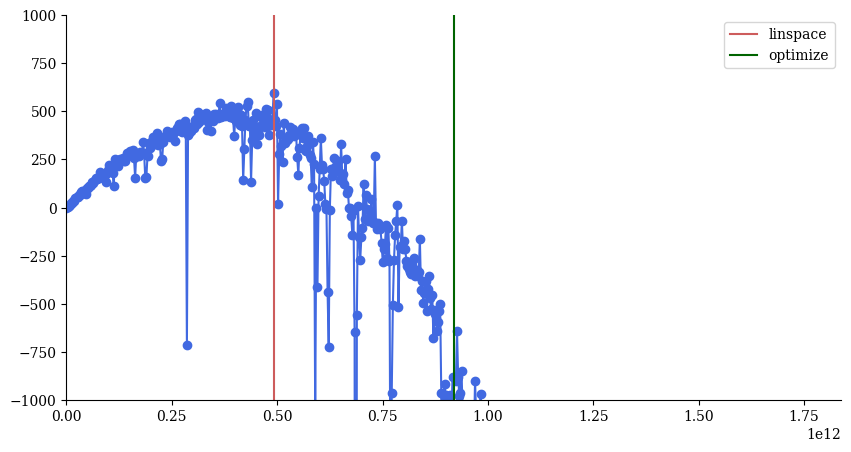

In [89]:
# TODO this curve is probably not smooth because:
# 1. The decimals are not being treated correctly between trades
# 2. The state of each pool is not being snapshot correctly (i.e. it's changing)

# Using i=17 as an example, the optimization does not converge
# to the global max due to the noise in the profit curve.
i = 17
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j) / 10
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit
        
f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue")
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

ax.set_xlim(0, 919573381759*2)
ax.set_ylim(-1000, 1000)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

In [82]:
# TODO handle failures:
# 1. `trade` method has diff outputs for diff pool types
# 2. LLAMMA snapshot context doesn't snapshot ERC20 balances
# 3. LLAMMA has no attribute `get_max_trade_size`

df = pd.DataFrame(columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"])

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(1, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()
        
        df.loc[i] = [cycle.trades[0].amt, best_amt_linspace, cycle.expected_profit, best_profit_linspace]
        
    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")
        
df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

[ERROR][00:57:28][root]-492739: Cycle 6 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:28][root]-492739: Cycle 7 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:33][root]-492739: Cycle 14 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:33][root]-492739: Cycle 15 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:39][root]-492739: Cycle 22 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:39][root]-492739: Cycle 23 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:44][root]-492739: Cycle 30 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:44][root]-492739: Cycle 31 failed to optimize: unsupported operand type(s) for /=: 'tuple' and 'int'
[ERROR][00:57:44][root]-492739: Cycle 32 failed to optimize: 'SimLLAMMAPool' objec

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,0,1,0.000,0.0
1,19897912969508400660480,1,-32.266,0.0
2,95064883984029821435904,1,-298.518,0.0
3,768572943356782,1,-0.000,0.0
4,150344932342639,1,-0.000,0.0
5,170405152331282247581696,1,-92.861,0.0
8,74626215133983987990528,69630515065368386469888,43.175,39.0
9,97985999374791999488000,125998074880190425595904,118.473,102.0
10,125053711731312,1,-0.000,0.0
11,151543857532952727519232,1,-46.041,0.0
